In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import math

In [2]:
import pickle
import numpy as np

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [82]:
batch_size=32

In [83]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [84]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [85]:
random_batch=next(iter(train_dataloader))

In [86]:
random_batch[0][0].shape

torch.Size([3, 32, 32])

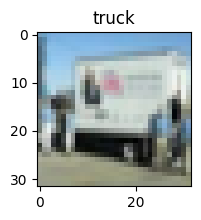

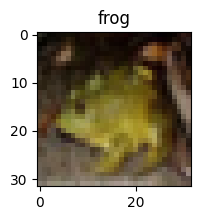

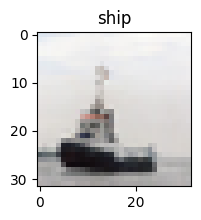

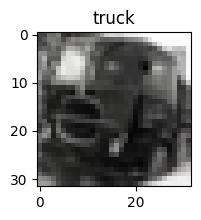

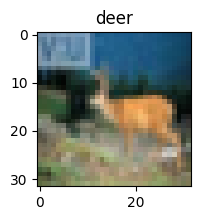

In [87]:
for i in range(5):
  plt.figure(figsize=(2,2))
  img = random_batch[0][i] / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  #print(classes[random_batch[1][i]])
  plt.title(classes[random_batch[1][i]])
  plt.show()

In [93]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
device

device(type='cuda')

100%|██████████| 1563/1563 [01:04<00:00, 24.25it/s]


train loss: 1.349921627069084
test loss: 1.0075499390641722
train accuracy: 0.5090371081253998
test accuracy: 0.643370607028754


100%|██████████| 1563/1563 [01:04<00:00, 24.14it/s]


train loss: 0.822719248227408
test loss: 0.8337767994441925
train accuracy: 0.7113923544465771
test accuracy: 0.7158546325878594


100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s]


train loss: 0.6062014877357623
test loss: 0.5755526160660643
train accuracy: 0.7898672424824056
test accuracy: 0.803214856230032


100%|██████████| 1563/1563 [01:04<00:00, 24.40it/s]


train loss: 0.4726890374263433
test loss: 0.5308413969727751
train accuracy: 0.8360924504158669
test accuracy: 0.8145966453674122


100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


train loss: 0.36152676900494807
test loss: 0.47819265619682044
train accuracy: 0.8743202175303902
test accuracy: 0.8398562300319489
Finished Training


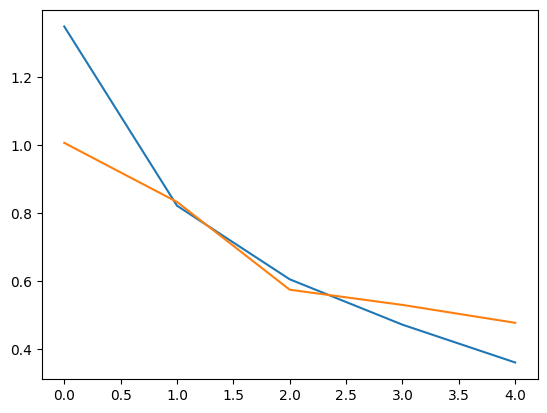

In [102]:
losses_train=[]
losses_test=[]
metrics_train=[]
metrics_test=[]
model=ResNet(BasicBlock, [2,2,2,2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
CRloss = nn.CrossEntropyLoss()
for epoch in range(5):
    loss=0
    accs_train=[]
    accs_test=[]
    for batch in tqdm(train_dataloader):
        model.train()
        inputs, labels = batch
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        outputs = model(inputs)
        loss_train = CRloss(outputs, labels)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss += loss_train.item()

        _, predicted = torch.max(outputs.data, 1)

        accs_train.append((predicted == labels).sum().item() / batch_size)

    loss = loss/len(train_dataloader)
    losses_train.append(loss)

    model.eval()
    loss=0
    for batch in test_dataloader:
        inputs, labels = batch

        inputs = inputs.to(device).float()
        labels = labels.to(device)

        outputs = model(inputs.float().to(device))
        loss_test = CRloss(outputs, labels.to(device))

        loss += loss_test.item()

        _, predicted = torch.max(outputs, 1)

        accs_test.append((predicted == labels).sum().item() / batch_size)


    loss = loss/len(test_dataloader)
    losses_test.append(loss)
    metrics_test.append(np.mean(accs_test))

    print("train loss:", losses_train[-1])
    print("test loss:", losses_test[-1])
    print("train accuracy:", np.mean(accs_train))
    print("test accuracy:", np.mean(accs_test))
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_test, label='Test Loss')
    #plt.plot(f1_scores_list, label='F1 Score')
    #plt.legend(loc='best')
    #plt.show()


print('Finished Training')

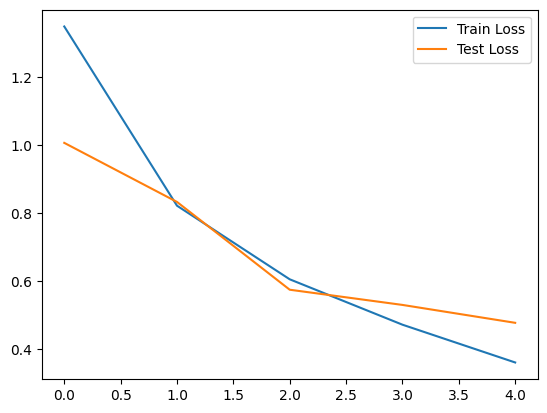

In [105]:
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_test, label='Test Loss')
plt.legend()

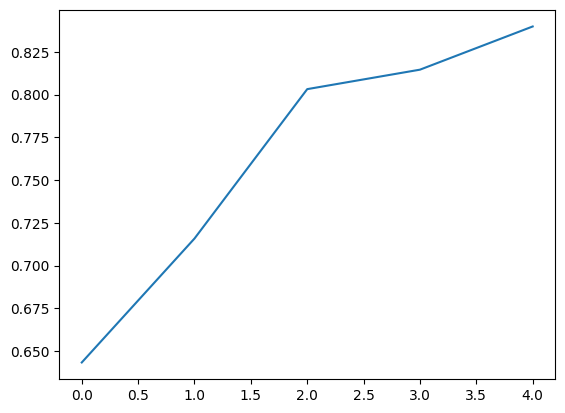

In [106]:
plt.plot(metrics_test)